In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loader import PathDataModule
from tqdm import tqdm

# --- 1. Configuration and Data Loading ---
config_path = 'config_score.json'
config_data = json.load(open(config_path, 'r'))
print(config_data)

{'dataset': 'icews14', 'storage_dir': '../data/', 'embedding_config': './embedding_config.json', 'criteria': 'score', 'train_ratio': 0.3, 'hidden_dim': 256, 'max_hops': 4, 'num_neg': 50, 'num_threads': 8, 'decay_factor': 0.8, 'max_fanout': 200, 'beam_width': 20, 'max_epochs': 2, 'batch_size': 8, 'dim_feedforward': 256, 'nhead': 4, 'num_layers': 6, 'dropout': 0.1, 'store': 'model', 'save_text_embeddings': True, 'shallow': True, 'pre_scan': ['train'], 'adjust_no_neg_paths_samples': True, 'max_adjust': 5.0, 'positive_deviation': True, 'embedding': 'all', 'test_time': 1, 'num_ckpt': 2, 'scale_loss': True, 'chi2': False, 'lr': 0.0001, 'wandb_project': 'thesis-graph', 'neg_per_pos': 3}


In [2]:
import os, requests, json, pprint

cid  = os.getenv("CONTAINER_ID")          # ← set by Vast.ai inside every container
key  = os.getenv("CONTAINER_API_KEY")     # ← scoped token for this one instance
assert cid and key, "Not running on a Vast.ai container!"

resp = requests.get(
    f"https://console.vast.ai/api/v0/instances/{cid}/",
    headers={"Authorization": f"Bearer {key}",
             "accept": "application/json"},
    timeout=10,
)

info = resp.json()
print("Effective vCPUs:", info['instances']["cpu_cores_effective"])
# print(info['instances'].keys())

Effective vCPUs: 12.0


In [3]:

# Initialize the DataModule and load the data
print("Setting up DataModule...")
dm = PathDataModule(config_path=config_path, batch_size=32)
dm.setup('fit')
print("Data loaded.")


Setting up DataModule...
Setting up data for stage: fit
Setting up data for split: train
Pre-scan enabled for train split. Running full data validation...

--- Pre-scanning and filtering train data points ---
Scanning 210056 edges in train split...


Scanning edges: 100%|██████████| 210056/210056 [00:00<00:00, 1198159.08it/s]



Pre-scan Results for train:
  Total edges scanned: 210056
  Valid edges (has pos & neg paths): 0 (0.0%)
  Missing positive paths: 52639 (25.1%)
  Missing negative paths: 210056 (100.0%)
  Empty negative paths: 0 (0.0%)

⚠️  WARNING: Some edges are missing required path data!
  Filtering train split to keep only 0 valid edges.
  New edge count for train: 0
--- Pre-scan complete ---

Use shallow embeddings: True at config ./embedding_config.json
Loading KGE model proxy for train split from ../data/transe_icews14_all_config.json
KGEModelProxy initialized on cuda
Loaded model state from ../data/transe_icews14_all_model.pt to cuda
Device for KGE model: cuda:0
Loaded 0 edges for train split.
Setting up data for split: valid
Pre-scan not configured for valid split. Skipping data validation.
Use shallow embeddings: True at config ./embedding_config.json
Loading KGE model proxy for valid split from ../data/transe_icews14_all_config.json
KGEModelProxy initialized on cuda
Loaded model state from

In [4]:

# --- 2. Data Extraction and Preparation ---
plot_data = []
split = 'test'  # You can change this to 'valid' or 'test'

print(f"Processing data for '{split}' split...")
edges_df = dm.data[split]
pos_paths = dm.pos_paths[split]
neg_paths = dm.neg_paths[split]


Processing data for 'test' split...


In [5]:
print(len(pos_paths), len(neg_paths))

27585 0


In [6]:

for eid, row in tqdm(edges_df.iterrows(), total=len(edges_df), desc="Extracting paths"):
    eid_str = str(eid)
    label = row['label']
    u = row['u']
    v = row['v']
    ts = row['ts']
    v_pos = row['v_pos']
    edge_type = row['edge_type']
    edge_meta = {}

    # Process positive path
    if eid_str in pos_paths and pos_paths[eid_str].get('nodes'):
        pos_path_len = len(pos_paths[eid_str]['nodes'])
        edge_meta = {
            'path_length': pos_path_len,
            # 'path_type': 'positive',
            'label': 'true_link' if label == 1 else 'false_link',
            'u': u, 'v': v, 'ts': ts, 'edge_type': edge_type,
            'v_pos': v_pos
            
        }
    else:
        edge_meta = {
            'path_length': 0,
            # 'path_type': 'positive',
            'label': 'true_link' if label == 1 else 'false_link',
            'u': u, 'v': v, 'ts': ts, 'edge_type': edge_type,
            'v_pos': v_pos
        }

    # # Process negative paths
    # if eid_str in neg_paths:
    #     # for neg_path_interleaved in neg_paths[eid_str]:
    #     #     # As per loader.py, nodes are at even indices
    #     #     neg_path_len = len(neg_path_interleaved[::2])
    #     #     plot_data.append({
    #     #         'path_length': neg_path_len,
    #     #         'path_type': 'negative',
    #     #         'label': 'true_link' if label == 1 else 'false_link'
    #     #     })
    #     edge_meta["num_neg"] = len(neg_paths[eid_str])

    plot_data.append(edge_meta)

Extracting paths: 100%|██████████| 29484/29484 [00:01<00:00, 26125.41it/s]


In [7]:

plot_df = pd.DataFrame(plot_data)
print("Data prepared for plotting.")


Data prepared for plotting.


In [8]:
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29484 entries, 0 to 29483
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   path_length  29484 non-null  int64 
 1   label        29484 non-null  object
 2   u            29484 non-null  int64 
 3   v            29484 non-null  int64 
 4   ts           29484 non-null  int64 
 5   edge_type    29484 non-null  int64 
 6   v_pos        29484 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.6+ MB


In [9]:
# edges_fp = os.path.join(config_data['storage_dir'], f"{config_data['dataset']}_edges.csv")
# df = pd.read_csv(edges_fp, index_col='edge_id')            
# split_map = {str(idx): row['split'] for idx, row in df.iterrows()}

In [10]:
# df.info()

In [11]:
# len(split_map.keys())

In [12]:
# list(split_map.values())[-1]

In [13]:
# split_code = {'pre': 0, 'train': 1, 'valid': 2, 'test': 3}

# print(f"Setting up data for split: {split}")

# pos_paths = {}
# with open(os.path.join(config_data['storage_dir'], f"{config_data['dataset']}_paths.txt")) as f:
#     n_str = f.readline()
#     n = int(n_str) if n_str and n_str.strip() else 0
#     for _ in tqdm(range(n)):
#         eid = f.readline().strip()
#         if not eid:
#             break
#         hops = int(f.readline())
#         nodes = [int(u) for u in f.readline().split()]
#         node_types = [int(t) for t in f.readline().split()]
#         edge_types_str = f.readline().strip().split()
#         edge_types = [int(et) for et in edge_types_str if et]
        
#         edge_timestamps_str = f.readline().strip().split()
#         edge_timestamps = [int(ts) for ts in edge_timestamps_str if ts]

#         if split_map.get(eid) == split_code[split]:
#             pos_paths[eid] = {
#                 "hops": hops,
#                 "nodes": nodes,
#                 "node_types": node_types,
#                 "edge_types": edge_types,
#                 "edge_timestamps": edge_timestamps
#             }


In [14]:
# len(pos_paths.keys())

In [15]:
plot_df

,path_length,label,u,v,ts,edge_type,v_pos
0,2,true_link,25,15,8016,41,18
1,2,true_link,5737,74,8016,9,8
2,2,true_link,88,8,8016,1,3
3,2,true_link,891,649,8016,9,131
4,2,true_link,132,115,8016,37,28
...,...,...,...,...,...,...,...
29479,4,false_link,249,646,8736,9,25
29480,4,false_link,249,3521,8736,9,25
29481,5,false_link,3509,721,8736,18,107
29482,5,false_link,3509,3170,8736,18,107


In [16]:
pos_df = plot_df[plot_df["path_length"] > 0].copy()
pos_df

,path_length,label,u,v,ts,edge_type,v_pos
0,2,true_link,25,15,8016,41,18
1,2,true_link,5737,74,8016,9,8
2,2,true_link,88,8,8016,1,3
3,2,true_link,891,649,8016,9,131
4,2,true_link,132,115,8016,37,28
...,...,...,...,...,...,...,...
29479,4,false_link,249,646,8736,9,25
29480,4,false_link,249,3521,8736,9,25
29481,5,false_link,3509,721,8736,18,107
29482,5,false_link,3509,3170,8736,18,107


In [17]:
temp = pos_df[pos_df["label"] == "true_link"].groupby("path_length").count()
temp

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
2,5440,5440,5440,5440,5440,5440
3,1327,1327,1327,1327,1327,1327
4,256,256,256,256,256,256
5,51,51,51,51,51,51
6,4,4,4,4,4,4
7,3,3,3,3,3,3


In [18]:
temp / temp.sum() * 100

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
2,76.825307,76.825307,76.825307,76.825307,76.825307,76.825307
3,18.740291,18.740291,18.740291,18.740291,18.740291,18.740291
4,3.615309,3.615309,3.615309,3.615309,3.615309,3.615309
5,0.720237,0.720237,0.720237,0.720237,0.720237,0.720237
6,0.056489,0.056489,0.056489,0.056489,0.056489,0.056489
7,0.042367,0.042367,0.042367,0.042367,0.042367,0.042367


In [19]:
pos_df[pos_df["label"] == "false_link"].groupby("path_length").count()

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
3,3988,3988,3988,3988,3988,3988
4,9861,9861,9861,9861,9861,9861
5,5462,5462,5462,5462,5462,5462
6,1010,1010,1010,1010,1010,1010
7,183,183,183,183,183,183


In [20]:
plot_df[plot_df["path_length"] < 2]

,path_length,label,u,v,ts,edge_type,v_pos
32,0,true_link,6893,4108,8016,9,1963
61,0,true_link,946,6894,8016,32,3919
69,0,true_link,6895,3581,8016,3,2314
71,0,true_link,1838,6896,8016,9,5155
92,0,true_link,6322,6897,8016,32,4621
...,...,...,...,...,...,...,...
29433,0,false_link,463,6988,8736,110,211
29441,0,false_link,2354,5089,8736,9,390
29460,0,false_link,7127,2981,8736,9,64
29461,0,false_link,7127,5718,8736,9,64


In [21]:
def calculate_metrics(group):
    """
    Calculates MRR and Hits@K for a group of predictions for a single query.
    The group contains one 'true_link' and multiple 'false_link' rows.
    A lower 'path_length' is considered a better score.
    """
    true_link = group[group['label'] == 'true_link']
    if true_link.empty:
        return pd.Series({
            'rank': 0, 'mrr': 1, 'hits@1': 1, 'hits@3': 1, 'hits@10': 1
        })

    # Lower path_length is better.
    true_path_length = true_link['path_length'].min()
    
    # Rank is 1 + number of negative samples with a better (smaller) or equal path length.
    # We use '<=' because if scores are tied, the true link does not get the best rank.
    rank = 1 + group[(group['label'] == 'false_link') & (group['path_length'] < true_path_length)].shape[0]
    
    mrr = 1.0 / rank
    hits_at_1 = 1.0 if rank <= 1 else 0.0
    hits_at_3 = 1.0 if rank <= 3 else 0.0
    hits_at_10 = 1.0 if rank <= 10 else 0.0
    
    return pd.Series({
        'rank': rank,
        'mrr': mrr,
        'hits@1': hits_at_1,
        'hits@3': hits_at_3,
        'hits@10': hits_at_10
    })


In [22]:

# Group by the query identifiers.
# This assumes that for each (u, v, ts, edge_type) combination that forms a true link,
# there are corresponding negative samples that share these identifiers in some way
# that allows grouping. If negative samples have different u or v, the grouping key needs adjustment.
# Based on the request, we group by ('u', 'v', 'ts', 'edge_type').
grouped = plot_df.groupby(['u', 'ts', 'v_pos', 'edge_type'])


In [23]:

# Apply the function to each group and get the results.
metrics_df = grouped.apply(calculate_metrics, include_groups=False).reset_index()


In [24]:

print("Metrics per query:")
metrics_df


Metrics per query:


,u,ts,v_pos,edge_type,rank,mrr,hits@1,hits@3,hits@10
0,0,8016,17,0,1.0,1.0,1.0,1.0,1.0
1,0,8016,17,1,1.0,1.0,1.0,1.0,1.0
2,0,8016,17,4,1.0,1.0,1.0,1.0,1.0
3,0,8016,17,35,1.0,1.0,1.0,1.0,1.0
4,0,8016,151,35,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
7366,7119,8688,4142,18,1.0,1.0,1.0,1.0,1.0
7367,7120,8688,960,4,1.0,1.0,1.0,1.0,1.0
7368,7124,8712,226,9,1.0,1.0,1.0,1.0,1.0
7369,7126,8736,389,21,1.0,1.0,1.0,1.0,1.0


In [28]:

print("\nAverage metrics across all queries:")
metrics_df[['mrr', 'hits@1', 'hits@3', 'hits@10']].mean() * 100



Average metrics across all queries:


mrr         92.191245
hits@1      84.818885
hits@3      99.850767
hits@10    100.000000
dtype: float64

<Axes: ylabel='Frequency'>

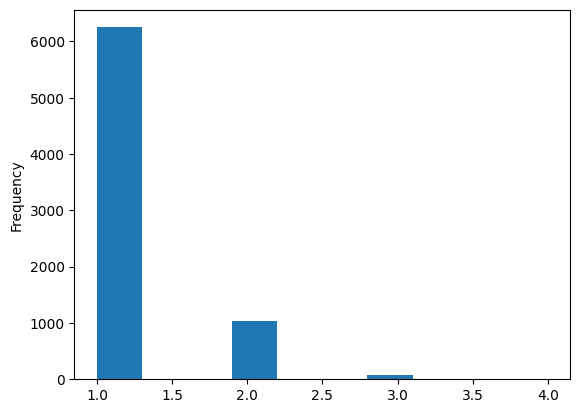

In [26]:
metrics_df['rank'].plot.hist(bins=10)

In [27]:
metrics_df.groupby('rank').count()

,u,ts,v_pos,edge_type,mrr,hits@1,hits@3,hits@10
rank,,,,,,,,
1.0,6252,6252,6252,6252,6252,6252,6252,6252
2.0,1028,1028,1028,1028,1028,1028,1028,1028
3.0,80,80,80,80,80,80,80,80
4.0,11,11,11,11,11,11,11,11
